# Train a simple image classifier

**Task**: Train a flower classifier.

Outline:

1. Load the data
    1. Download the dataset.
    2. Set up the dataloaders (which handles train-validation split, batching, and resizing)
2. Train a model
    1. Get a foundation model (an EfficentNet in our case)
    2. Fine-tune it.
3. Get the model's predictions on an image.

This notebook includes tasks (marked with "**Task**") and blank code cells (labeled `# your code here`) to fill in your answers.

## Setup

**Run this code.** (You do not need to read or modify the code in this section to successfully complete this assignment.)

In [1]:
# Check versions of Keras and Tensorflow
!pip list | egrep 'keras|tensorflow$'

keras                                    2.13.1
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.3.5


In [2]:
import os
# Results are better with the TensorFlow backend; this is probably a bug in Keras 3 but I haven't tracked it down.
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
Keras version: 2.13.1, backend: tensorflow
GPUs: 1


## Configure our experiments

You'll be invited to change parameters in this code block later; for now just run it as-is.

In [3]:
class config:
    seed = 0
    learning_rate = 1e-3
    epochs = 1
    batch_size = 16
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"
    use_zero_init = True

In [4]:
# Reproducibility
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
#
# Set a seed so that the results are the same every time this is run.
keras.utils.set_random_seed(config.seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

### Load the data

We'll use a dataset of flower images for this example, but you can later switch this out for another dataset as long as you keep the file-and-folder structure.

The details of the code in this section are not important at this time; just run these cells.

In [5]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    extract=True,
)

228813984/228813984 [==============================] - 8s 0us/step


Let's see what just got downloaded.

In [6]:
data_path = Path(path_to_downloaded_file).parent / 'flower_photos'
!ls {data_path}

LICENSE.txt  daisy  dandelion  roses  sunflowers  tulips


We'll use a Keras helper function to load the data.

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [7]:
# Define which classes we want to use, in what order.
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


Let's show some example images.

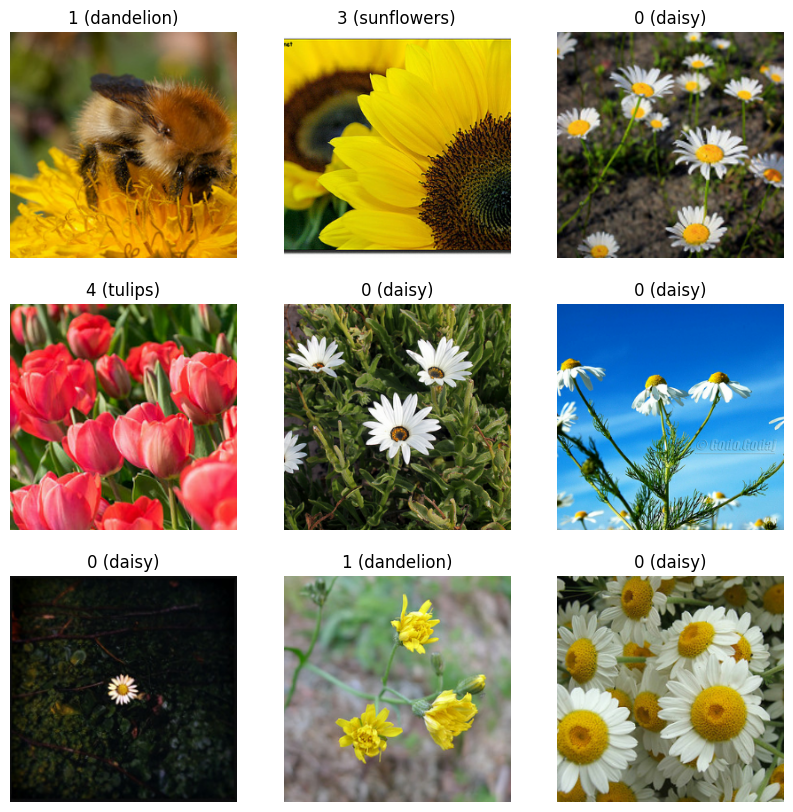

In [8]:
[[example_images, example_labels]] = train_dataset.take(1)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')
# Alternative approach (doesn't show labels)
# keras_cv.visualization.plot_image_gallery(example_images, value_range=(0, 255))

### Train a model

We'll unpack this code over the next several weeks. For now, pay attention to the progress bar that will (eventually) show on the last line of the output.

In [9]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Zero the output-layer weights (they were randomly initialized, which adds noise to gradients when fine-tuning)
# I was reminded of this by https://twitter.com/wightmanr/status/1742570388016758822
if config.use_zero_init:
    output_layer = model.layers[-1]
    output_layer.set_weights([w * 0 for w in output_layer.weights])

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# Train the model. (Note: this may show some warnings, and it may stop without showing
# progress for up to a minute while it translates the model to run on the GPU.)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs
)

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "image_classifier"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, None, None, 3)]   0         Y          
                                                                            
 efficient_net_v2b0_backbon  (None, None, None, 1280   5919312   Y          
 e (EfficientNetV2Backbone)  )                                              
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1280)              0         Y          
 ling2D)                                                                    
                                                                            
 predictions (Dense)         (None, 5)                 6405      Y          
                                                                            
Total params: 5925717 (22.60 MB)
Trainable params:

2024-01-19 17:02:55.475228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inimage_classifier/efficient_net_v2b0_backbone/block2b_/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


184/184 [==============================] - 68s 107ms/step - loss: 0.4814 - accuracy: 0.8454 - val_loss: 0.2548 - val_accuracy: 0.9101


**Task**: Fill in the table below, using the last line from the output above:

- Training set accuracy: 83.38%
- Validation set accuracy: 89.24%
- Training loss: .4898
- Validation loss: .3815

### Make some predictions

20329/20329 [==============================] - 0s 2us/step


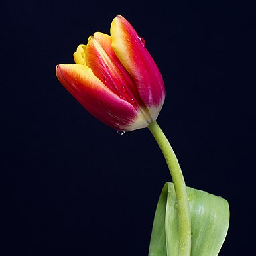

In [10]:
# Load a new image
image_file = keras.utils.get_file(origin='https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Beautiful_red_tulip.jpg/382px-Beautiful_red_tulip.jpg')
image = keras.utils.load_img(image_file, target_size=(256, 256), keep_aspect_ratio=True)
display(image)

In [11]:
probabilities = model.predict(np.array(image)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False)

1/1 [==============================] - 2s 2s/step


,class,prob
4,tulips,0.962948
1,dandelion,0.013863
3,sunflowers,0.009767
0,daisy,0.006863
2,roses,0.006560


**Task**: Is the second column a valid probability distribution (ignoring round-off errors)? Describe why or why not.

Yes, it adds to one.

**Task**: Write code to show the category with the highest predicted probability. To do this, use the `np.argmax` function and the `class_names` list.

*Hint*: look at the value of the `probabilities` variable by making a code chunk with just `probabilities` in it.

In [12]:
class_names[np.argmax(probabilities)]

'tulips'

## Experimentation

Try changing one parameter in the `config` code block above and rerun the notebook. What effect does this have on the validation accuracy? (Run the same parameters a few times with different values for `config.seed` to check if the result is robust.)

Tip: an easy way to track your experiemnts is to copy and paste the final progress-bar line.

It increasted the accuracy.
184/184 [==============================] - 67s 108ms/step - loss: 0.4814 - accuracy: 0.8454 - val_loss: 0.2548 - val_accuracy: 0.9101

## Optional extension: try out your own image

Finish the code below to be able to try out the classifier on your own image.

In [13]:
from ipywidgets import widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [14]:
if len(uploader.data) > 0:
    image_file = io.BytesIO(uploader.data[0])
    image = keras.utils.load_img(image_file, target_size=(256, 256), keep_aspect_ratio=True)
    display(image)

    # TODO: finish showing the predictions on this image and show the most likely class.
    # your code here